In [1]:
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS,WordCloud
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np 
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,  Dense,Bidirectional,LSTM
import pandas as pd 

2025-05-27 12:44:30.480726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748349870.675957      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748349870.733972      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
df_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

In [3]:
df_true.text[0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [95]:
df_fake.sample(n = 5)

,title,text,subject,date
20425,SHOCKER! WAS MUSLIM TERRORIST GAY? Used Gay Da...,"Of course, Mateen s Muslim father vehemently d...",left-news,"Jun 13, 2016"
11944,"SAY WHAT? Trump-Hater, RINO John McCain Admits...",Sworn Donald Trump enemy John McCain admitted ...,politics,"Jan 11, 2017"
2178,GOP Rep. Steve King Just Went FULL White Supr...,While it should surprise absolutely no one tha...,News,"March 12, 2017"
5527,Joe Walsh: Americans Are Too Dumb To Understa...,Former Republican Congressman Joe Walsh appear...,News,"July 10, 2016"
2560,Mark Cuban Hilariously BURNS Trump For Attack...,Donald Trump just got his ass handed to him by...,News,"February 12, 2017"


In [96]:
df_true.sample(n = 5)

,title,text,subject,date
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
11957,Argentina set to pass pension reform despite m...,BUENOS AIRES (Reuters) - Argentina s Congress ...,worldnews,"December 18, 2017"
17611,First Turkish military convoy enters Syria's I...,BEIRUT (Reuters) - A first convoy of the milit...,worldnews,"October 12, 2017"
3131,House speaker optimistic on tax reform prospec...,WASHINGTON (Reuters) - The top Republican in t...,politicsNews,"June 19, 2017"
246,U.S. tax repatriation plan may not cure long-t...,NEW YORK (Reuters) - Investors looking for the...,politicsNews,"December 8, 2017"


In [97]:
df_fake['label'] = 0
df_true['label'] = 1

In [98]:
df = pd.concat([df_fake, df_true],ignore_index = True)

In [99]:
df = df.drop('subject',axis = 1)

In [100]:
df.isnull().sum()

title    0
text     0
date     0
label    0
dtype: int64

In [101]:
fake_label = df[df['label'] == 0][['text','title']]
true_label = df[df['label'] == 1][['text','title']]


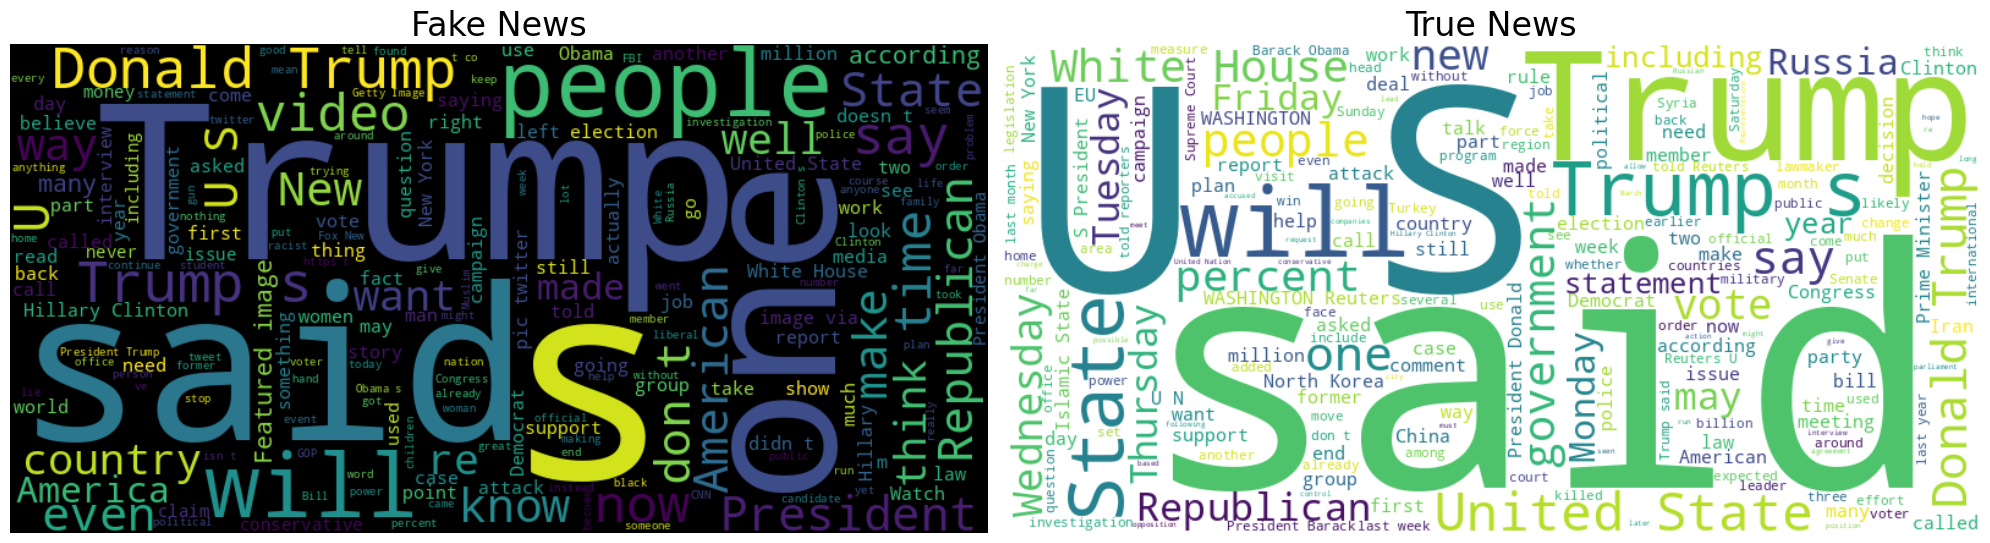

In [102]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define stopwords
stopwords = set(STOPWORDS)

# Sample 5000 rows from each label group (if available)
fake_sample = fake_label.sample(n=5000, random_state=42)
true_sample = true_label.sample(n=5000, random_state=42)

# Combine 'text' and 'title' for sampled rows
fake_text = ' '.join(fake_sample['title'].fillna('') + ' ' + fake_sample['text'].fillna(''))
true_text = ' '.join(true_sample['title'].fillna('') + ' ' + true_sample['text'].fillna(''))

# Create WordClouds
fake_wc = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords).generate(fake_text)
true_wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(true_text)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fake_wc, interpolation='bilinear')
axs[0].set_title('Fake News', fontsize=24)
axs[0].axis('off')

axs[1].imshow(true_wc, interpolation='bilinear')
axs[1].set_title('True News', fontsize=24)
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [103]:
def text_processing(data):

    def decontracted(phrase):
        # specific
        phrase= re.sub(r'<br /><br />',' ',phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"', " ", phrase)
        phrase = re.sub(r"_","",phrase)
        phrase = re.sub(r"don't","do not",phrase)
        phrase = re.sub(r"Trump","",phrase)
        return phrase
    stopwords=set(STOPWORDS)

    # Combining all the above stundents
    from tqdm import tqdm
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(data['merged'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = ' '.join(e.lower() for e in sentance.split() if e not in stopwords)
        preprocessed_reviews.append(sentance.strip())


    porter = PorterStemmer()
    list2 = []
    for  sentence in preprocessed_reviews:
      list1 = []
      for words in sentence.split():
        list1.append(porter.stem(words))

      list2.append(' '.join(list1))
    return(list2)

In [104]:
def join_sentence(df, col1, col2):
    return (df[col1].fillna('') + ' ' + df[col2].fillna('')).str.strip()


In [105]:
df['merged'] = join_sentence(df,'title','text')

In [106]:
df['merged'].sample(n = 5)

9550     WOW! LATINO GROUP Aired TERROR-LIKE TV Ad Only...
10046    BREAKING NEWS: SEBASTIAN GORKA OUT…Are Ivanka ...
35779    India PM Modi's party seen sweeping state poll...
4005     Military Expert Vows To Take Trump Up On His C...
26090    NSA chief on Russia-U.S. cyber unit: Now is 'n...
Name: merged, dtype: object

In [107]:
x = text_processing(df)

100%|██████████| 44898/44898 [00:19<00:00, 2360.97it/s]


In [108]:
df['clean_text'] = x
y = df.label.values

In [109]:
import gensim

In [110]:
X=[d.split() for d in df['clean_text'].tolist()]

In [111]:
type(X[0])

list

In [112]:
DIM =100
w2v_model = gensim.models.Word2Vec(sentences = X, vector_size = DIM, window = 5, min_count = 1)

In [113]:
len(w2v_model.wv)

309619

In [114]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [115]:
X = tokenizer.texts_to_sequences(x)

In [116]:
tokenizer.word_index

{'s': 1,
 'the': 2,
 'said': 3,
 'i': 4,
 'will': 5,
 'u.s.': 6,
 'presid': 7,
 'state': 8,
 't': 9,
 'republican': 10,
 'peopl': 11,
 'one': 12,
 'say': 13,
 'new': 14,
 '-': 15,
 'donald': 16,
 'hous': 17,
 'democrat': 18,
 'said.': 19,
 'it': 20,
 'govern': 21,
 'call': 22,
 'unit': 23,
 'he': 24,
 'obama': 25,
 'nation': 26,
 'in': 27,
 'support': 28,
 'make': 29,
 'white': 30,
 'clinton': 31,
 'told': 32,
 'go': 33,
 'report': 34,
 'senat': 35,
 'time': 36,
 'american': 37,
 '(reuters)': 38,
 'last': 39,
 'year': 40,
 'use': 41,
 'two': 42,
 'offici': 43,
 'want': 44,
 'includ': 45,
 'vote': 46,
 'take': 47,
 'a': 48,
 'elect': 49,
 'campaign': 50,
 'polit': 51,
 'news': 52,
 'parti': 53,
 'former': 54,
 'even': 55,
 'first': 56,
 'work': 57,
 'right': 58,
 'we': 59,
 'countri': 60,
 'hillari': 61,
 'secur': 62,
 'mani': 63,
 'back': 64,
 'group': 65,
 'washington': 66,
 'but': 67,
 'may': 68,
 'come': 69,
 'show': 70,
 'now': 71,
 'need': 72,
 'think': 73,
 'made': 74,
 'offic': 

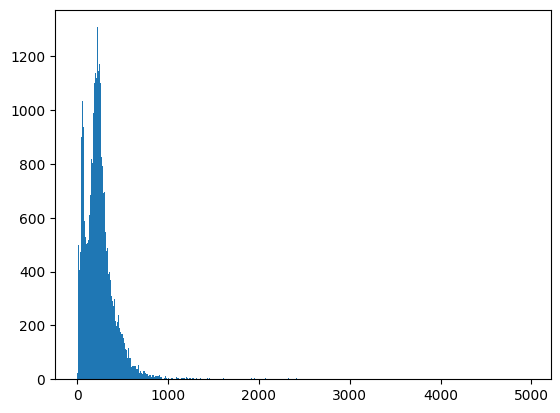

In [117]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [118]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 1000
x = pad_sequences(X, maxlen = maxlen)

In [119]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [120]:
import numpy as np

def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix


In [121]:
embedding_vectors = get_weight_matrix(w2v_model)

In [122]:
embedding_vectors.shape

(309620, 100)

In [143]:
import torch.optim as optim
import torch
import torch.nn as nn

In [147]:
from torch.utils.data import TensorDataset, DataLoader, random_split
torch.manual_seed(42)
np.random.seed(42)

In [145]:
embedding_tensor = torch.tensor(embedding_vectors, dtype=torch.float)

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim=128):
        super().__init__()
        num_embeddings, embedding_dim = embedding_tensor.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_tensor)
        self.embedding.weight.requires_grad = False  # freeze embeddings
        
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embedded = self.embedding(x)             # (batch, seq_len, embedding_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]                  # (batch, hidden_dim)
        out = self.fc(last_hidden)
        return self.sigmoid(out).squeeze()

# Prepare dataset
X_tensor = torch.tensor(x, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.float)

dataset = TensorDataset(X_tensor, y_tensor)

# Train-test split 80-20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Instantiate model and move to device
model = LSTMClassifier(embedding_tensor, hidden_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

epochs = 6

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_loss = running_loss / total
    train_acc = correct / total
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

Epoch 1/6 | Train Loss: 0.1135 | Train Acc: 0.9616
Epoch 2/6 | Train Loss: 0.0352 | Train Acc: 0.9886
Epoch 3/6 | Train Loss: 0.0242 | Train Acc: 0.9921
Epoch 4/6 | Train Loss: 0.0083 | Train Acc: 0.9973
Epoch 5/6 | Train Loss: 0.0066 | Train Acc: 0.9979
Epoch 6/6 | Train Loss: 0.0080 | Train Acc: 0.9973


In [150]:
torch.save(model.state_dict(), "/kaggle/working/lstm_fake_news_model.pth")


In [151]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [152]:
# Save maxlen, vocabulary size, and embedding dimension
params = {
    "maxlen": maxlen,
    "vocab_size": vocab_size,
    "embedding_dim": DIM
}

with open("params.pkl", "wb") as f:
    pickle.dump(params, f)


In [153]:
np.save("embedding_vectors.npy", embedding_vectors)
